In [2]:
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import umap
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
sns.set()
sns.set_style('whitegrid', {'axes.grid' : False})

In [3]:
df_1 = pd.read_csv('sql_export_retention.csv')
df_2 = pd.read_csv('sql_export_connections.csv')
df_3 = pd.read_csv('export_payments.csv')
df_4 = pd.read_csv ('sql_export_chat_requests_received.csv')
df_5 = pd.read_csv('sql_export_chat_requests_sent.csv')
df_6 = pd.read_csv('sql_export_crons_spent.csv')
df_7 = pd.read_csv('sql_export_rating_given.csv')
df_8 = pd.read_csv('sql_export_rating_received.csv')
banned = pd.read_csv('banned_since_jan19_2020_03_03.csv')
df = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8])


In [4]:
# CLEANING

## Missing values
df.isna().sum()
### Dropping 1 row without user_id
df.drop(df[df.user_id.isna()].index,axis=0, inplace=True)
### user_gender : drop nan
missing_gender = df[df.user_gender.isna()]
df.drop(df[df.user_gender.isna()].index,axis=0, inplace=True)
### user_country : 1 missing value : check in db seems to be in Africa/Windhoek time zone so filled with NA (Namibia)
df.user_country.fillna('NA', inplace = True)
### max_match_num : this col is nan when the user has not made anny connection during the 5 first days => fill with 0
df.max_match_num.fillna(0, inplace = True)
### max_connection_num: this col is nan when the user has not made anny connection during the 5 first days => fill with 0
df.max_connection_num.fillna(0, inplace = True)
### payments : the 4 payment columns are nan when the user has not made any purchase during the 5 first days => fill with 0
df.crowns_usd_5d.fillna(0, inplace = True)
df.sub_usd_5d.fillna(0, inplace = True)
df.sub_re_usd_5d.fillna(0, inplace = True)
df.discount_usd_5d.fillna(0, inplace = True)
### payments : replace subscription renewal by subscription 
df['sub_usd_5d'] = df.eval('sub_usd_5d + sub_re_usd_5d')
df.drop('sub_re_usd_5d', axis=1, inplace=True)
### chat requests : same as previous=> fill with 0
df.chat_request_received_5d.fillna(0, inplace = True)
df.chat_request_sent_5d.fillna(0, inplace = True)
### crowns spent : same as previous
df.crowns_spent_chat_5d.fillna(0, inplace = True)
df.crowns_spent_message_5d.fillna(0, inplace = True)
df.crowns_spent_match_now_5d.fillna(0, inplace = True)
df.crowns_spent_discover_5d.fillna(0, inplace = True)
df.crowns_spent_pick_5d.fillna(0, inplace = True)
df.crowns_spent_instant_match_now_5d.fillna(0, inplace = True)
df.crowns_spent_more_pick_5d.fillna(0, inplace = True)
df.crowns_spent_average_rating_5d .fillna(0, inplace = True)
df.crowns_spent_another_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_attractive_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_close_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_serious_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_new_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_alone_5d.fillna(0, inplace = True)
df.crowns_spent_more_rating_5d .fillna(0, inplace = True)
df.crowns_spent_rematch_5d .fillna(0, inplace = True)
df.crowns_spent_reset_rating_5d.fillna(0, inplace = True)
df.crowns_spent_pick_from_ratings_5d.fillna(0, inplace = True)
df.crowns_spent_stalk_5d.fillna(0, inplace = True)
### ratings : same as previous
df.rating_given.fillna(0, inplace = True)
df.avg_rating_given .fillna(0, inplace = True)
df.rating_received.fillna(0, inplace = True)
df.avg_rating_received.fillna(0, inplace = True)

# Drop the "curated" crowns spending types because new feature
col_drop = ['crowns_spent_curated_user_5d','crowns_spent_curated_user_attractive_5d','crowns_spent_curated_user_close_5d','crowns_spent_curated_user_serious_5d', 'crowns_spent_curated_user_new_5d', 'crowns_spent_curated_user_alone_5d']
df.drop(col_drop, axis=1, inplace=True)

# Create a total login column
df['login_5d']= df.eval('1+d1+d2+d3+d4')
# Create a total spent column and a has_spent columns
df['total_spent']=df.eval('crowns_usd_5d+sub_usd_5d+discount_usd_5d')
df['has_spent']=df.total_spent.apply(lambda x: 1 if x>0 else 0)
# Create a total crowns_spent column
df['total_crowns_spent'] = df.eval ('crowns_spent_chat_5d+crowns_spent_message_5d+ crowns_spent_match_now_5d+crowns_spent_discover_5d+crowns_spent_pick_5d+crowns_spent_instant_match_now_5d+crowns_spent_more_pick_5d+crowns_spent_average_rating_5d+crowns_spent_another_5d+crowns_spent_more_rating_5d+ crowns_spent_rematch_5d+crowns_spent_reset_rating_5d+ crowns_spent_pick_from_ratings_5d+ crowns_spent_stalk_5d')
df['has_spent_crowns'] = df.total_crowns_spent.apply(lambda x: 1 if x>0 else 0)
# Create a got_connection column
df['got_connection'] = df.max_connection_num.apply(lambda x: 1 if x>0 else 0)
# Countries
def countries(x):
    top_lst = ['FR','IT', 'DE', 'BR', 'BE', 'CH', 'US', 'GB', 'AT', 'NL', 'CA']
    eur_lst = ['AL', 'AD', 'AM', 'BY', 'BA', 'BG', 'CY','CZ', 'DK', 'EE', 'ES', 'FO', 'FI',
               'GI','GR', 'HU', 'HR', 'IE', 'IS', 'LI', 'LT', 'LU', 'LV', 'MC', 'MK', 'MT', 'NO', 'PL', 'PT', 'RO', 'RU', 'SE', 'SI', 'SK', 'SM', 'TR', 'UA', 'VA']
    asia_lst = ['CN', 'YE', 'IN','AU','NZ', 'HK', 'JP', 'AF', 'AZ', 'BH', 'BD', 'BT', 'BN', 'KH', 'GE', 'ID', 'IR', 'IQ', 'IL', 'JO', 'KZ', 'KW', 'KG', 'LA', 'LB', 'MO', 'MY', 'MV', 'MN', 'MM', 'NP', 'KP', 'OM', 'PK', 'PH', 'QA', 'SA', 'SG', 'KR', 'LK', 'SY', 'TW', 'TJ', 'TH', 'TM', 'AE', 'UZ', 'VN']
    africa_lst = ['MA', 'CI','RE', 'DZ', 'NG', 'EG', 'TN','AE']
    southam_lst = ['MX','AR', 'CO','CL','PE', 'BO', 'BR', 'VG', 'CR', 'CU', 'CW', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GP', 'GT', 'GY', 'HT', 'JM', 'NI', 'PA', 'PY', 'PR', 'BL', 'KN', 'LC', 'MF', 'PM', 'VC', 'SR', 'TT', 'UY', 'VE']
    if x in top_lst :
        return x
    elif x in eur_lst:
        return 'other EU'
    elif x in asia_lst:
        return 'other Asia'
    elif x in africa_lst:
        return 'other Africa'
    elif x in southam_lst:
        return 'other South America'
    else :
        return 'other'
df['country']= df.user_country.apply(lambda x: countries(x))
df.drop('user_country', axis=1, inplace=True)

# Acquisition
def paid(x):
    if x in ['Organic', 'Google Organic Search']:
        return 0
    else :
        return 1
df['paid_user'] = df.network.apply(lambda x: paid(x))
df.drop('network', axis=1, inplace=True)

# Drop banned accounts
banned['status']= 'banned'
banned.rename ( columns = {'Id' : 'user_id'}, inplace=True)
df = df.merge(banned, on='user_id', how='left')
df.drop(df[df['status']=='banned'].index, inplace = True)
df.drop('status', axis=1, inplace= True)


## Check the types
df.dtypes
df['install_date'] = pd.to_datetime(df['install_date'])
df['max_match_num'] = df['max_match_num'].astype(int)
df['max_connection_num'] = df['max_connection_num'].astype(int)


# SPLIT INTO 2 DATAFRAMES : MEN / WOMEN

df_m = df[df.user_gender=='m']
df_w = df[df.user_gender=='w']

# Visualization

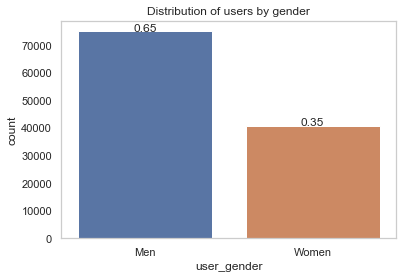

In [6]:
## Gender repartition
ax = sns.countplot(data=df, x = 'user_gender')
ax.set_title('Distribution of users by gender')
ax.set(xticklabels=['Men', 'Women'])
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 


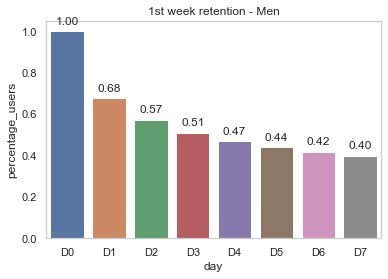

In [7]:
## Retention
D0_m = float(df_m.shape[0]/df_m.shape[0])
D1_m = float(df_m.d1.sum()/df_m.shape[0])
D2_m = float(df_m.d2.sum()/df_m.shape[0])
D3_m= float(df_m.d3.sum()/df_m.shape[0])
D4_m = float(df_m.d4.sum()/df_m.shape[0])
D5_m = float(df_m.d5.sum()/df_m.shape[0])
D6_m = float(df_m.d6.sum()/df_m.shape[0])
D7_m = float(df_m.d7.sum()/df_m.shape[0])
retention_m = pd.DataFrame(data =[['D0',D0_m],['D1',D1_m],['D2',D2_m],['D3',D3_m],['D4',D4_m],['D5',D5_m],['D6',D6_m],['D7',D7_m]], columns = ['day', 'percentage_users'])
ax1= sns.barplot(x= retention_m.day, y= retention_m.percentage_users)
ax1.set_title('1st week retention - Men')
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


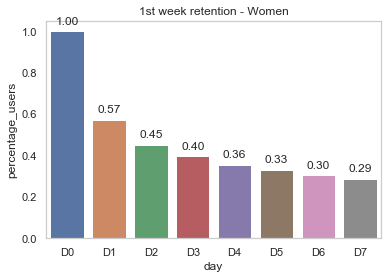

In [8]:
D0_w = float(df_w.shape[0]/df_w.shape[0])
D1_w = float(df_w.d1.sum()/df_w.shape[0])
D2_w = float(df_w.d2.sum()/df_w.shape[0])
D3_w= float(df_w.d3.sum()/df_w.shape[0])
D4_w = float(df_w.d4.sum()/df_w.shape[0])
D5_w = float(df_w.d5.sum()/df_w.shape[0])
D6_w = float(df_w.d6.sum()/df_w.shape[0])
D7_w = float(df_w.d7.sum()/df_w.shape[0])
retention_w = pd.DataFrame(data =[['D0',D0_w],['D1',D1_w],['D2',D2_w],['D3',D3_w],['D4',D4_w],['D5',D5_w],['D6',D6_w],['D7',D7_w]], columns = ['day', 'percentage_users'])
ax2= sns.barplot(x= retention_w.day, y= retention_w.percentage_users)
ax2.set_title('1st week retention - Women')
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

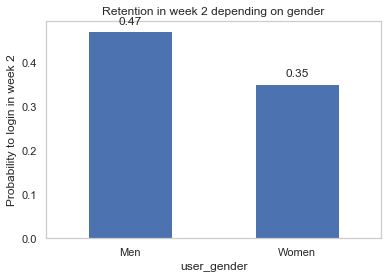

In [9]:
## Retention in week 2 according to gender
ax = df.groupby('user_gender').mean()['w2'].plot.bar(title = 'Retention in week 2 depending on gender')
ax.set(xticklabels=['Men', 'Women'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

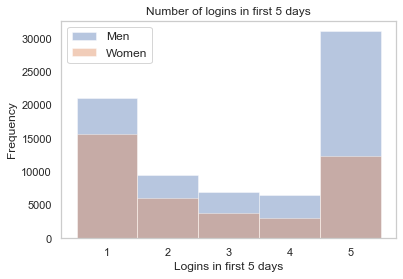

In [10]:
## Distribution number of login per week

new_bins=[0.5,1.5,2.5,3.5,4.5,5.5]
sns.distplot(df_m['login_5d'],  kde=False, label='Men', bins = new_bins)
sns.distplot(df_w['login_5d'],  kde=False, label='Women',bins = new_bins)
plt.title('Number of logins in first 5 days')
plt.xlabel('Logins in first 5 days')
plt.ylabel('Frequency')
plt.legend(prop={'size': 12})

Text(0, 0.5, 'Number of logins in first 5 days')

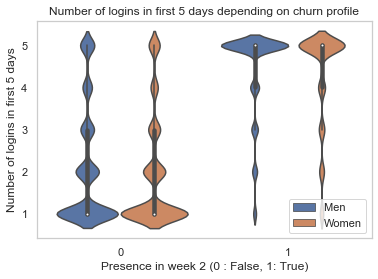

In [11]:
ax= sns.violinplot(x = 'w2', y = 'login_5d', hue = 'user_gender', data = df)
ax.set_title('Number of logins in first 5 days depending on churn profile')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Men ", "Women"])
ax.set_xlabel('Presence in week 2 (0 : False, 1: True)')
ax.set_ylabel('Number of logins in first 5 days')

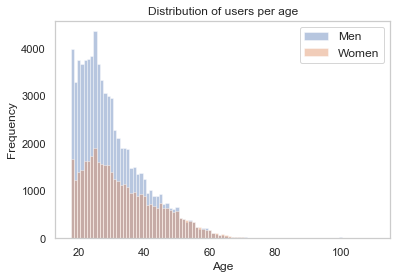

In [12]:
## Age
### Age distribution by gender
new_bins2= np.arange(df.user_age.min(), df.user_age.max()+1.5)-0.5
sns.distplot(df_m['user_age'],  kde=False, label='Men', bins = new_bins2)
sns.distplot(df_w['user_age'],  kde=False, label='Women',bins = new_bins2)
plt.title('Distribution of users per age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(prop={'size': 12})


Text(0, 0.5, 'Age')

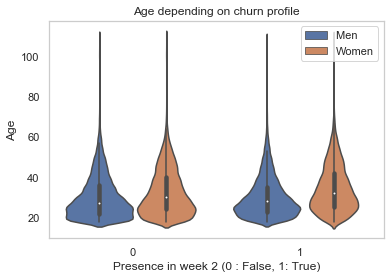

In [13]:
### Age distribution by gender depending on churn profile
ax= sns.violinplot(x = 'w2', y = 'user_age', hue = 'user_gender', data = df)
ax.set_title('Age depending on churn profile')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Men ", "Women"])
ax.set_xlabel('Presence in week 2 (0 : False, 1: True)')
ax.set_ylabel('Age')


Text(0.5, 0.98, 'Distribution of users by age')

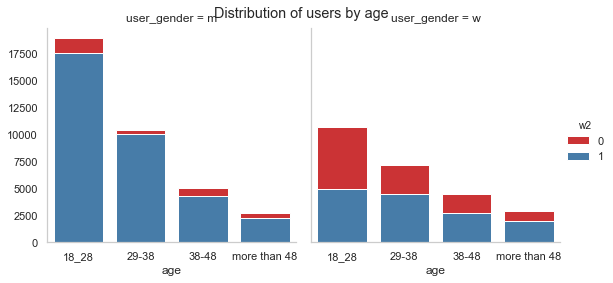

In [14]:
### Age bins distribution by gender depending on churn profile
df['age']= pd.cut(df['user_age'], [18, 28, 38, 48,150], labels = [ '18_28','29-38', '38-48', 'more than 48'])
g = sns.FacetGrid(data=df,col='user_gender',hue = 'w2',palette='Set1',size=4,aspect=1).map(sns.countplot,'age',order=df.age.value_counts().index).add_legend()
g.set_xticklabels(rotation = 0)
g.fig.suptitle('Distribution of users by age')

Text(0.5, 0.98, 'Distribution of user by platform')

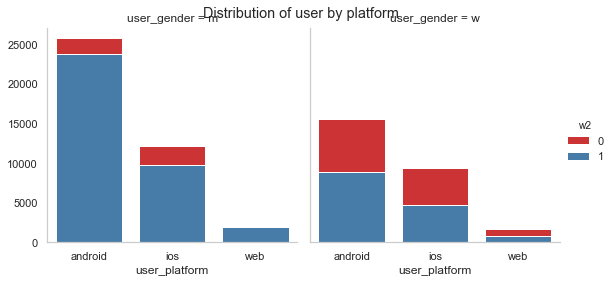

In [15]:
## Platform
g = sns.FacetGrid(data=df,col='user_gender',hue = 'w2',palette='Set1',size=4,aspect=1).map(sns.countplot,'user_platform',order=df.user_platform.value_counts().index).add_legend()
g.fig.suptitle('Distribution of user by platform')


Text(0.5, 0.98, 'Distribution of user by acquisition mean')

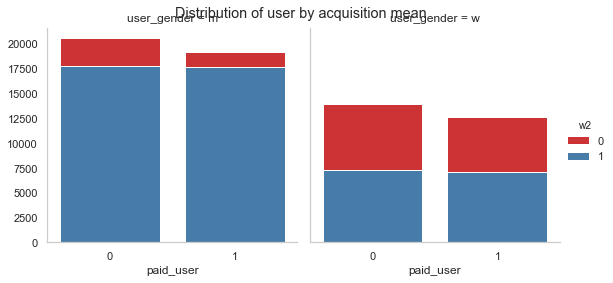

In [16]:
## Acquisition : organic vs paid users
### Distribution of users per acquisition mean
g = sns.FacetGrid(data=df,col='user_gender',hue = 'w2',palette='Set1',size=4,aspect=1).map(sns.countplot,'paid_user',order=df.paid_user.value_counts().index).add_legend()
g.fig.suptitle('Distribution of user by acquisition mean')

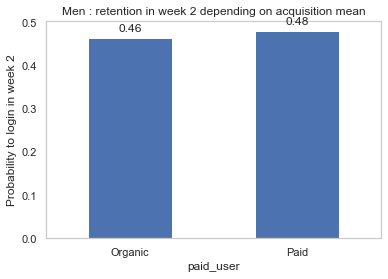

In [17]:
### Retention in week 2 depending on acquisition mean  : men vs women   
ax = df_m.groupby('paid_user').mean()['w2'].plot.bar(title = 'Men : retention in week 2 depending on acquisition mean')
ax.set(xticklabels=['Organic', 'Paid'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

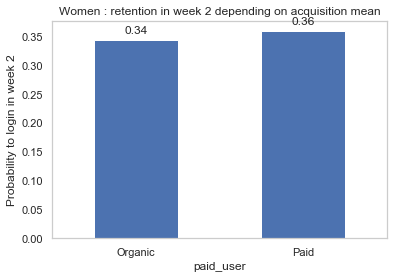

In [18]:
ax = df_w.groupby('paid_user').mean()['w2'].plot.bar(title = 'Women : retention in week 2 depending on acquisition mean')
ax.set(xticklabels=['Organic', 'Paid'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


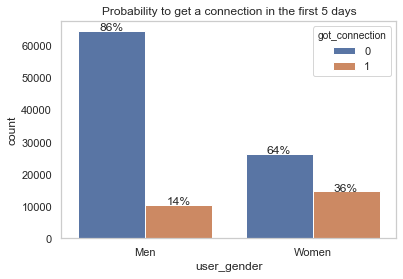

In [19]:
## Connection
### Proportion of users getting at least one connection in the first 5 days per gender
ax = sns.countplot(data=df, x = 'user_gender', hue = 'got_connection')
ax.set_title('Probability to get a connection in the first 5 days')
ax.set(xticklabels=['Men', 'Women'])
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")


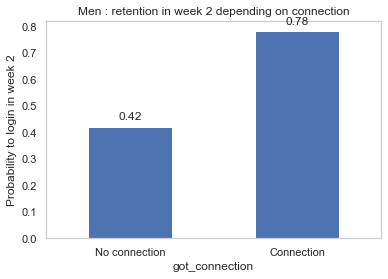

In [20]:
### Retention depending on getting a connection : men vs women
ax = df_m.groupby('got_connection').mean()['w2'].plot.bar(title = 'Men : retention in week 2 depending on connection')
ax.set(xticklabels=['No connection', 'Connection'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


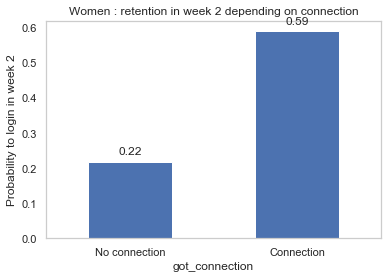

In [21]:
ax = df_w.groupby('got_connection').mean()['w2'].plot.bar(title = 'Women : retention in week 2 depending on connection')
ax.set(xticklabels=['No connection', 'Connection'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


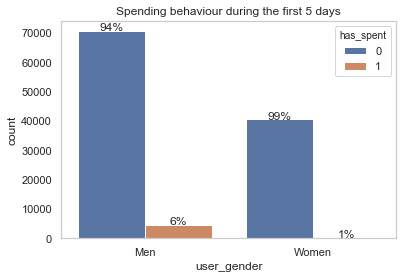

In [22]:
## Spenders
### Proportion of spenders per gender

ax = sns.countplot(data=df, x = 'user_gender', hue = 'has_spent')
ax.set_title('Spending behaviour during the first 5 days')
ax.set(xticklabels=['Men', 'Women'])
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")


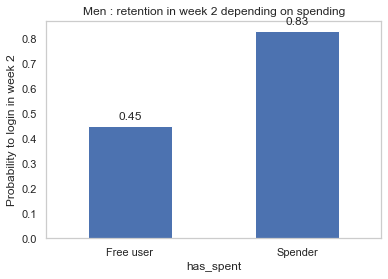

In [23]:
### Retention depending on spending behaviour : men vs women
ax = df_m.groupby('has_spent').mean()['w2'].plot.bar(title = 'Men : retention in week 2 depending on spending')
ax.set(xticklabels=['Free user', 'Spender'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

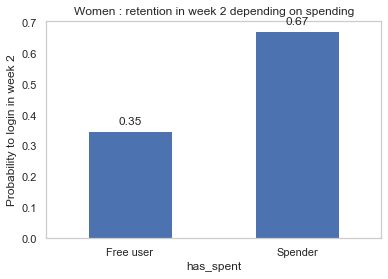

In [24]:
ax = df_w.groupby('has_spent').mean()['w2'].plot.bar(title = 'Women : retention in week 2 depending on spending')
ax.set(xticklabels=['Free user', 'Spender'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


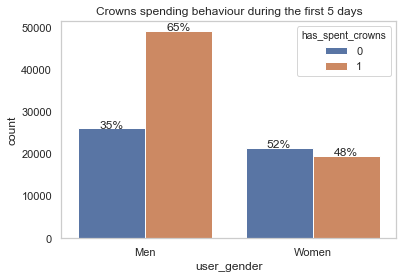

In [25]:
## Crowns spending
### Proportion of crown spenders per gender
ax = sns.countplot(data=df, x = 'user_gender', hue = 'has_spent_crowns')
ax.set_title('Crowns spending behaviour during the first 5 days')
ax.set(xticklabels=['Men', 'Women'])
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")


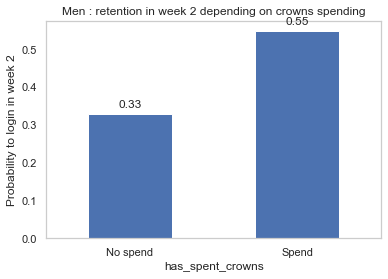

In [26]:
### Retention depending on crowns spending behaviour : men vs women
ax = df_m.groupby('has_spent_crowns').mean()['w2'].plot.bar(title = 'Men : retention in week 2 depending on crowns spending')
ax.set(xticklabels=['No spend', 'Spend'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

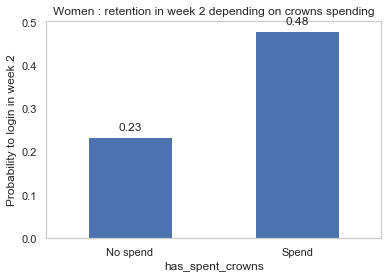

In [27]:
ax = df_w.groupby('has_spent_crowns').mean()['w2'].plot.bar(title = 'Women : retention in week 2 depending on crowns spending')
ax.set(xticklabels=['No spend', 'Spend'])
ax.set_ylabel('Probability to login in week 2')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
